# Retrieval Augumented Generation (RAG) inference

***This notebook works best with the `conda_python3` on the `ml.t3.large` instance***.

---

At this point our slide deck data is ingested into Amazon OpenSearch Service Serverless collection. We are now ready to talk to our slide deck using a large multimodal model. We are using the [Anthropic’s Claude 3 Sonnet foundation model](https://aws.amazon.com/about-aws/whats-new/2024/03/anthropics-claude-3-sonnet-model-amazon-bedrock/) for this purpose.

## Step 1. Setup

Install the required Python packages and import the relevant files.

In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt

In [2]:
import os
import io
import sys
import json
import glob
import boto3
import base64
import logging
import requests
import botocore
import sagemaker
import numpy as np
import pandas as pd
import globals as g
from PIL import Image
from pathlib import Path
from typing import List, Dict
from IPython.display import Image
from urllib.parse import urlparse
from botocore.auth import SigV4Auth
from pandas.core.series import Series
from sagemaker import get_execution_role
from botocore.awsrequest import AWSRequest
from utils import get_cfn_outputs, get_text_embedding, get_llm_response
from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
!pygmentize globals.py

"""
Global variables used throughout the code.
"""
import os
import boto3
import sagemaker

BUCKET_PREFIX: str = "multimodal"
BUCKET_EMB_PREFIX: str = f"{BUCKET_PREFIX}/osi-embeddings-json"
BUCKET_IMG_PREFIX: str = f"{BUCKET_PREFIX}/img"

S3_MODEL_CODE_PREFIX: str = "code"
S3_MODEL_PREFIX: str = "model"

# Amazon Titan Text model
AWS_REGION: str = boto3.Session().region_name
TITAN_URL: str = f"https://bedrock-runtime.{AWS_REGION}.amazonaws.com"
TITAN_MODEL_ID: str = "amazon.titan-embed-text-v1"
CLAUDE_MODEL_ID: str = "anthropic.claude-3-sonnet-20240229-v1:0"
ACCEPT_ENCODING: str = "application/json"
CONTENT_ENCODING: str = "application/json"

# Amazon OpenSearch Service Serverless
OS_SERVICE: str = "aoss"

# local files and folder structure
IMAGE_DIR: str = "img"
IMAGE_FILE_EXTN: str = ".jpg"
B64_ENCODED_IMAGES_DIR: str = os.path.join(IMAGE_DIR, "b64_images")

# this is the slide deck to which we will be talking to. Replace with your slide deck's URL to analyze a different deck
SLIDE_D

In [4]:
logging.basicConfig(format='[%(asctime)s] p%(process)s {%(filename)s:%(lineno)d} %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

## Step 2. Create an OpenSearch client and SageMaker Predictor object

We create an OpenSearch client so that we can query the vector database for embeddings (slides) similar to the questions that we might want to ask of our slide deck and then we create a SageMaker [`Predictor`](https://sagemaker.readthedocs.io/en/stable/api/inference/predictors.html) to run inference using the LLaVA model given the slide we retrieved from OpenSearch.

Get the name of the OpenSearch Service Serverless collection endpoint and index name from the CloudFormation stack outputs.

In [5]:
outputs = get_cfn_outputs(g.CFN_STACK_NAME)
host = outputs['MultimodalCollectionEndpoint'].split('//')[1]
index_name = outputs['OpenSearchIndexName']
logger.info(f"opensearchhost={host}, index={index_name}")


[2024-03-22 22:27:19,565] p11886 {1663180104.py:4} INFO - opensearchhost=qg3ibzbsjrmc1szxroih.us-west-2.aoss.amazonaws.com, index=slides


In [6]:
session = boto3.Session()
credentials = session.get_credentials()
auth = AWSV4SignerAuth(credentials, g.AWS_REGION, g.OS_SERVICE)

os_client = OpenSearch(
    hosts = [{'host': host, 'port': 443}],
    http_auth = auth,
    use_ssl = True,
    verify_certs = True,
    connection_class = RequestsHttpConnection,
    pool_maxsize = 20
)

[2024-03-22 22:27:19,622] p11886 {credentials.py:1075} INFO - Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


## Step 3. Read for RAG

We now have all the pieces for RAG. Here is how we _talk to our slide deck_.

1. Convert the user question into embeddings using the Titan Text Embeddings model.

1. Find the most similar slide (image) corresponding to the the embeddings (for the user question) from the vector database (OpenSearch Serverless).

1. Now ask Claude3 to answer the user question using the retrieved image description for the most similar slide.

In [7]:
bedrock = boto3.client(service_name="bedrock-runtime", endpoint_url=g.TITAN_URL)

A handy function for similarity search in the vector db

In [8]:
def find_similar_data(text_embeddings: np.ndarray, size: int) -> Dict:
    query = {
        "size": size,
        "query": {
            "knn": {
                "vector_embedding": {
                    "vector": text_embeddings,
                    "k": size
                }
            }
        }
    }
    try:
        image_based_search_response = os_client.search(body=query, index=index_name)
        # remove the vector_embedding field for readability purposes, it was needed during
        # the similarity search (by the vector db), we do not need it any more.
        source = image_based_search_response['hits']['hits'][0]['_source'].pop('vector_embedding')
        logger.info(f"received response from OpenSearch, response={json.dumps(image_based_search_response, indent=2)}")
    except Exception as e:
        logger.error(f"error occured while querying OpenSearch index={index_name}, exception={e}")
        image_based_search_response = None
    return image_based_search_response

### Question 1

Create a prompt and convert it to embeddings.

In [9]:
question: str = "How does Inf2 compare in performance to comparable EC2 instances? I need numbers."
text_embedding = get_text_embedding(bedrock, question)

Find the most similar slide from the vector db.

In [10]:
vector_db_response: Dict = find_similar_data(text_embedding, 1)

[2024-03-22 22:27:20,544] p11886 {base.py:259} INFO - POST https://qg3ibzbsjrmc1szxroih.us-west-2.aoss.amazonaws.com:443/slides/_search [status:200 request:0.508s]
[2024-03-22 22:27:20,545] p11886 {3947406868.py:18} INFO - received response from OpenSearch, response={
  "took": 368,
  "timed_out": false,
  "_shards": {
    "total": 0,
    "successful": 0,
    "skipped": 0,
    "failed": 0
  },
  "hits": {
    "total": {
      "value": 15,
      "relation": "eq"
    },
    "max_score": 0.006024055,
    "hits": [
      {
        "_index": "slides",
        "_id": "1%3A0%3AP6s-aI4BM1OxX5FEwPHl",
        "_score": 0.006024055,
        "_source": {
          "image_path": "s3://multimodal-blog2-bucket-597703351594/multimodal/img/CMP301_TrainDeploy_E1_20230607_SPEdited_image_26.jpg",
          "slide_text": "The image is a slide titled 'AWS Inferentia2 LLM performance' that compares the performance and cost metrics of AWS Inferentia2 accelerators with comparable Amazon EC2 instances for larg

Retrieve the image path from the search results and provide it to Claude3 along with the user question.

[2024-03-22 22:27:20,553] p11886 {3260149686.py:2} INFO - going to answer the question="How does Inf2 compare in performance to comparable EC2 instances? I need numbers." using the image "s3://multimodal-blog2-bucket-597703351594/multimodal/img/CMP301_TrainDeploy_E1_20230607_SPEdited_image_26.jpg"


download: s3://multimodal-blog2-bucket-597703351594/multimodal/img/CMP301_TrainDeploy_E1_20230607_SPEdited_image_26.jpg to ./CMP301_TrainDeploy_E1_20230607_SPEdited_image_26.jpg


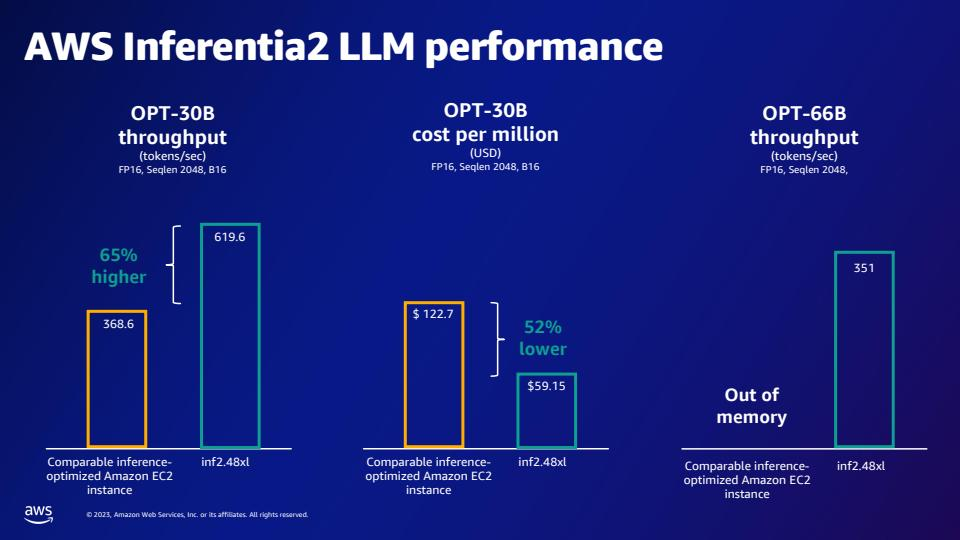

In [11]:
s3_img_path = vector_db_response.get('hits', {}).get('hits')[0].get('_source').get('image_path')
logger.info(f"going to answer the question=\"{question}\" using the image \"{s3_img_path}\"")

!aws s3 cp {s3_img_path} .
local_img_path = os.path.basename(s3_img_path)
Image(filename=local_img_path) 

In [12]:
slide_text = vector_db_response.get('hits', {}).get('hits')[0].get('_source').get('slide_text')

In [13]:
llm_response = get_llm_response(bedrock, question, slide_text)
print(llm_response)

According to the summary, the slide provides the following performance numbers comparing AWS Inferentia2 accelerators (inf2.48xl instance) with comparable inference-optimized EC2 instances for large language model workloads:

For the OPT-30B model:
- Throughput (tokens/sec): inf2.48xl = 619.6, EC2 instance = 368.6 (65% higher for inf2.48xl)
- Cost per million (USD): inf2.48xl = $122.7, EC2 instance = $59.15 (52% lower for EC2 instance)

For the OPT-66B model:
- Throughput (tokens/sec): inf2.48xl = 351.0, EC2 instance = Out of memory (EC2 instance could not run this model due to memory limitations)

So, for the larger OPT-66B model, the AWS Inferentia2 accelerators demonstrate a significant advantage in being able to handle the memory requirements, while providing higher throughput compared to the EC2 instances for both models, albeit at a higher cost per million for the OPT-30B model.


### Question 2

For this particular question, we are setting k=2 to get better results 

[2024-03-22 22:27:29,719] p11886 {base.py:259} INFO - POST https://qg3ibzbsjrmc1szxroih.us-west-2.aoss.amazonaws.com:443/slides/_search [status:200 request:1.666s]
[2024-03-22 22:27:29,725] p11886 {3947406868.py:18} INFO - received response from OpenSearch, response={
  "took": 1465,
  "timed_out": false,
  "_shards": {
    "total": 0,
    "successful": 0,
    "skipped": 0,
    "failed": 0
  },
  "hits": {
    "total": {
      "value": 26,
      "relation": "eq"
    },
    "max_score": 0.0087950835,
    "hits": [
      {
        "_index": "slides",
        "_id": "1%3A0%3ASqtDaI4BM1OxX5FEaPF_",
        "_score": 0.0087950835,
        "_source": {
          "image_path": "s3://multimodal-blog2-bucket-597703351594/multimodal/img/CMP301_TrainDeploy_E1_20230607_SPEdited_image_27.jpg",
          "slide_text": "The image is a slide titled 'Full stack AI/ML integration' that provides an overview of Amazon Web Services (AWS) offerings for AI/ML workloads. The slide is divided into three main s

download: s3://multimodal-blog2-bucket-597703351594/multimodal/img/CMP301_TrainDeploy_E1_20230607_SPEdited_image_10.jpg to ./CMP301_TrainDeploy_E1_20230607_SPEdited_image_10.jpg


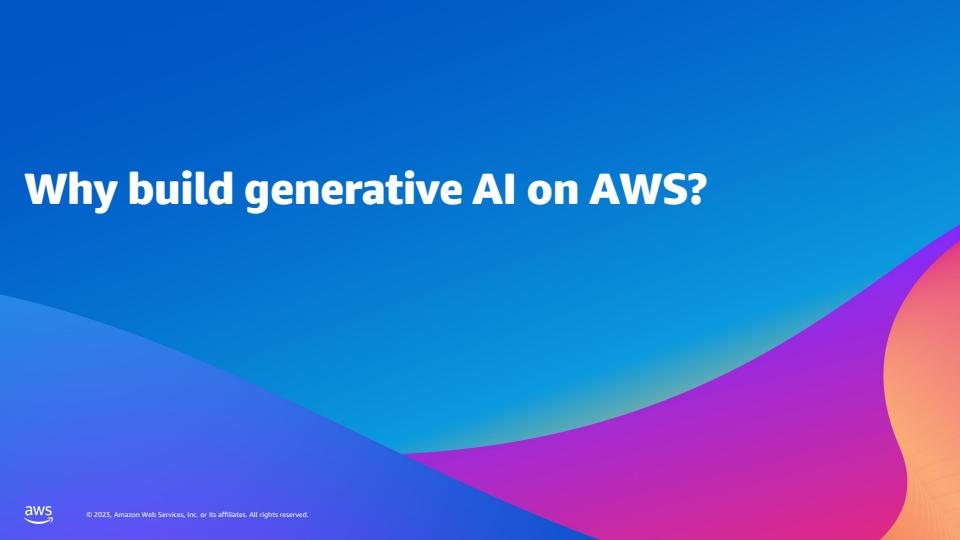

I do not know what the AWS AI/ML services provide based solely on the given summary, as it does not mention any specific details about the services themselves. The summary describes a presentation slide that poses the question 'Why build generative AI on AWS?', but it does not provide an answer to that question or any information about what the AI/ML services on AWS offer.


In [14]:
# create prompt and convert to embeddings
question: str = "As per the AI/ML flywheel, what do the AWS AI/ML services provide?"
text_embedding = get_text_embedding(bedrock, question)

#Find the 2 most similar slide from the vector db
vector_db_response: Dict = find_similar_data(text_embedding, 2)

# download image for local notebook display
s3_img_path = vector_db_response.get('hits', {}).get('hits')[1].get('_source').get('image_path')
logger.info(f"going to answer the question=\"{question}\" using the image \"{s3_img_path}\"")

!aws s3 cp {s3_img_path} .
local_img_path = os.path.basename(s3_img_path)
display(Image(filename=local_img_path))

# Ask Claude
slide_text = vector_db_response.get('hits', {}).get('hits')[1].get('_source').get('slide_text')
llm_response = get_llm_response(bedrock, question, slide_text)
print(llm_response)

### Question 3

What about slides that contain charts and graphs? We want to see if the LLaVA model can correcly analyze a graph and pull appropriate metrics from the slide. 

[2024-03-22 22:27:37,699] p11886 {base.py:259} INFO - POST https://qg3ibzbsjrmc1szxroih.us-west-2.aoss.amazonaws.com:443/slides/_search [status:200 request:0.071s]
[2024-03-22 22:27:37,701] p11886 {3947406868.py:18} INFO - received response from OpenSearch, response={
  "took": 30,
  "timed_out": false,
  "_shards": {
    "total": 0,
    "successful": 0,
    "skipped": 0,
    "failed": 0
  },
  "hits": {
    "total": {
      "value": 15,
      "relation": "eq"
    },
    "max_score": 0.0050151465,
    "hits": [
      {
        "_index": "slides",
        "_id": "1%3A0%3APas9aI4BM1OxX5FEa_E-",
        "_score": 0.0050151465,
        "_source": {
          "image_path": "s3://multimodal-blog2-bucket-597703351594/multimodal/img/CMP301_TrainDeploy_E1_20230607_SPEdited_image_13.jpg",
          "slide_text": "The image is a slide titled 'AI models are getting bigger' with a dark blue background. The slide presents a chart that shows the increasing size of AI models over time, measured by the

download: s3://multimodal-blog2-bucket-597703351594/multimodal/img/CMP301_TrainDeploy_E1_20230607_SPEdited_image_13.jpg to ./CMP301_TrainDeploy_E1_20230607_SPEdited_image_13.jpg


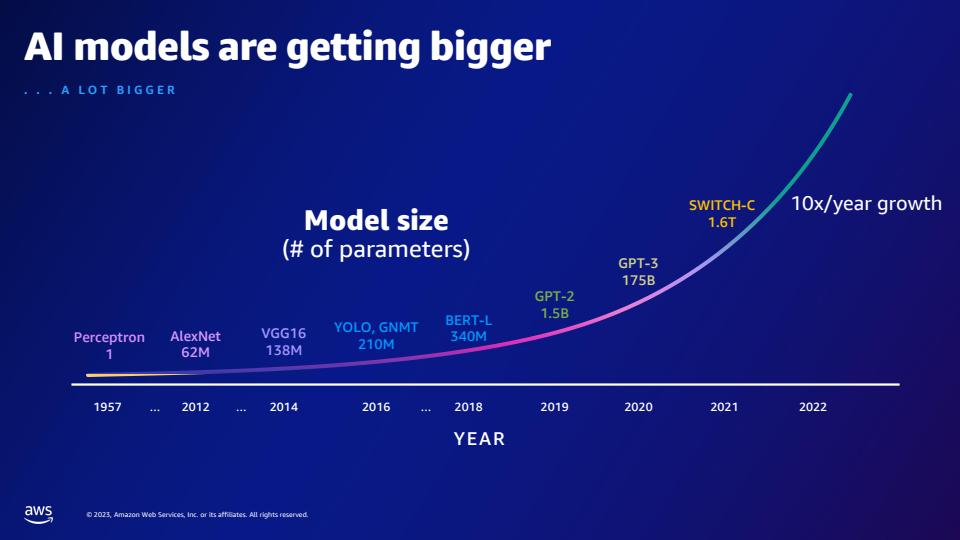

According to the information provided in the summary, GPT-3 has 175 billion (175B) parameters, while GPT-2 has 1.5 billion (1.5B) parameters. The numerical difference between the parameter size of GPT-2 and GPT-3 is 173.5 billion parameters. GPT-3 has significantly more parameters than GPT-2, approximately 116 times larger.


In [15]:
# create prompt and convert to embeddings
question: str = "Compared to GPT-2, how many more parameters does GPT-3 have? What is the numerical difference between the parameter size of GPT-2 and GPT-3?"
text_embedding = get_text_embedding(bedrock, question)

# vector db search
vector_db_response: Dict = find_similar_data(text_embedding, 1)

# download image for local notebook display
s3_img_path = vector_db_response.get('hits', {}).get('hits')[0].get('_source').get('image_path')
logger.info(f"going to answer the question=\"{question}\" using the image \"{s3_img_path}\"")

!aws s3 cp {s3_img_path} .
local_img_path = os.path.basename(s3_img_path)
display(Image(filename=local_img_path))

# Ask Claude
slide_text = vector_db_response.get('hits', {}).get('hits')[0].get('_source').get('slide_text')
llm_response = get_llm_response(bedrock, question, slide_text)
print(llm_response)

### Question 4

How about a question that cannot be answered based on this slide deck? We want to confirm that while some slide image will be retrieved but the Claude model does not hallucinate and correctly says  "I do not know".

[2024-03-22 22:27:41,547] p11886 {base.py:259} INFO - POST https://qg3ibzbsjrmc1szxroih.us-west-2.aoss.amazonaws.com:443/slides/_search [status:200 request:0.142s]
[2024-03-22 22:27:41,549] p11886 {3947406868.py:18} INFO - received response from OpenSearch, response={
  "took": 84,
  "timed_out": false,
  "_shards": {
    "total": 0,
    "successful": 0,
    "skipped": 0,
    "failed": 0
  },
  "hits": {
    "total": {
      "value": 15,
      "relation": "eq"
    },
    "max_score": 0.0022290535,
    "hits": [
      {
        "_index": "slides",
        "_id": "1%3A0%3ARatBaI4BM1OxX5FEIvFv",
        "_score": 0.0022290535,
        "_source": {
          "image_path": "s3://multimodal-blog2-bucket-597703351594/multimodal/img/CMP301_TrainDeploy_E1_20230607_SPEdited_image_6.jpg",
          "slide_text": "The image is a slide titled 'The road to generative AI'. It has a dark blue background and text in white.\n\nThe slide presents a visual representation of the path or progression towards

download: s3://multimodal-blog2-bucket-597703351594/multimodal/img/CMP301_TrainDeploy_E1_20230607_SPEdited_image_6.jpg to ./CMP301_TrainDeploy_E1_20230607_SPEdited_image_6.jpg


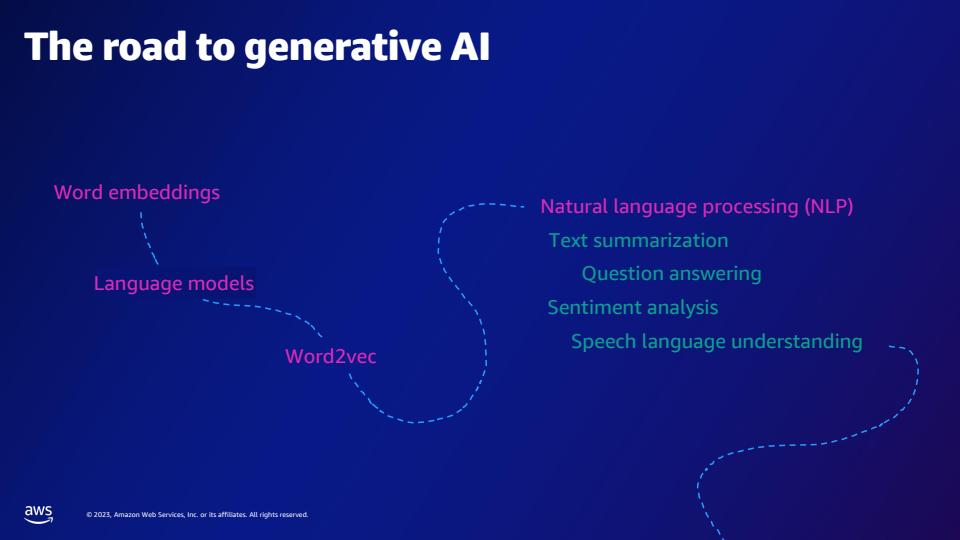

I do not know what quarks are in particle physics from the given summary. The summary is about word embeddings, language models, natural language processing tasks, and their role in enabling generative AI. It does not contain any information about particle physics or quarks.


In [16]:
# create prompt and convert to embeddings
question: str = "What are quarks in particle physics?"
text_embedding = get_text_embedding(bedrock, question)

# vector db search
vector_db_response: Dict = find_similar_data(text_embedding, 1)

# download image for local notebook display
s3_img_path = vector_db_response.get('hits', {}).get('hits')[0].get('_source').get('image_path')
logger.info(f"going to answer the question=\"{question}\" using the image \"{s3_img_path}\"")

!aws s3 cp {s3_img_path} .
local_img_path = os.path.basename(s3_img_path)
display(Image(filename=local_img_path))

# Ask Claude
slide_text = vector_db_response.get('hits', {}).get('hits')[0].get('_source').get('slide_text')
llm_response = get_llm_response(bedrock, question, slide_text)
print(llm_response)

## Clean Up
